In [1]:
import pykoop
import sklearn
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
from numpy.polynomial.legendre import Legendre
from scipy.special import legendre # legendre(n)用于生成n阶勒让德多项式。
# 勒让德多项式是一类正交多项式，常用于数值分析、物理问题的求解以及函数逼近。
from scipy.integrate import fixed_quad 
#fixed_quad是一种使用固定阶数的高斯求积法进行数值积分的函数。
#它对于积分光滑函数非常精确和高效。
from scipy.linalg import eig
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
# eig：用于计算一般方阵的特征值和特征向量。
# eigh：用于计算厄米特（Hermitian）矩阵或实对称矩阵的特征值和特征向量。
# eigsh：用于计算大型稀疏对称矩阵的特征值。
from tools import *
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings

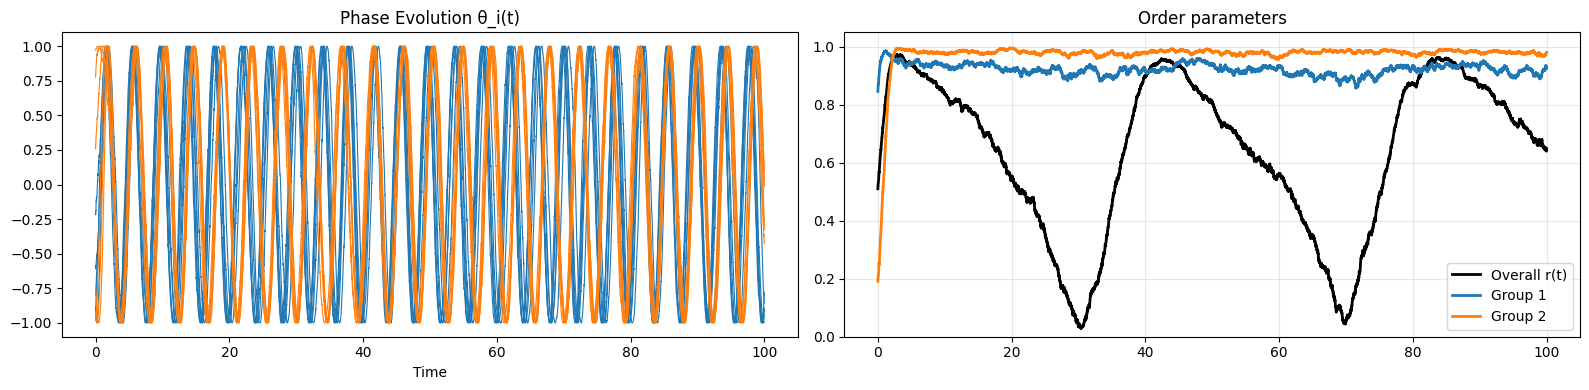

In [3]:
# ▶ 运行示例
X_embed, K_matrix,_,_ = plot_clustered_kuramoto(
    N=12,          
    n_clusters=2,  
    K_intra=2,   
    K_inter=0.1,   
    noise=0.01,
    T=100
)

In [4]:
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('pl', pykoop.PolynomialLiftingFn(order=1,interaction_only=True)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='rank',truncation_param=4)),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error


0.05538601170533993

In [15]:
# 径向基函数
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('rbf', pykoop.RbfLiftingFn(rbf='gaussian',centers=pykoop.ClusterCenters(estimator=sklearn.cluster.KMeans(n_clusters=24)),shape=1)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.023906744170413843)

In [19]:
#kernal，随机傅立叶表征
kp = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'rff',
        pykoop.KernelApproxLiftingFn(
            kernel_approx=pykoop.RandomFourierKernelApprox(
                n_components=100,
                random_state=0,
            )),
    )],
    regressor=pykoop.Edmd(),
)

kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.04927083670256271)

In [22]:
#延迟嵌入，Hankel
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('delay', pykoop.DelayLiftingFn(n_delays_state=2)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='rank',truncation_param=4)),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.08357105909849975)

总特征值数量: 24
res阈值: 0.01
可靠特征值数量 (res <= 0.01): (4, [0, 1, 2, 3])
虚假特征值数量 (res > 0.01): 20
残差RES的范围：0.014652 ~ 0.240912


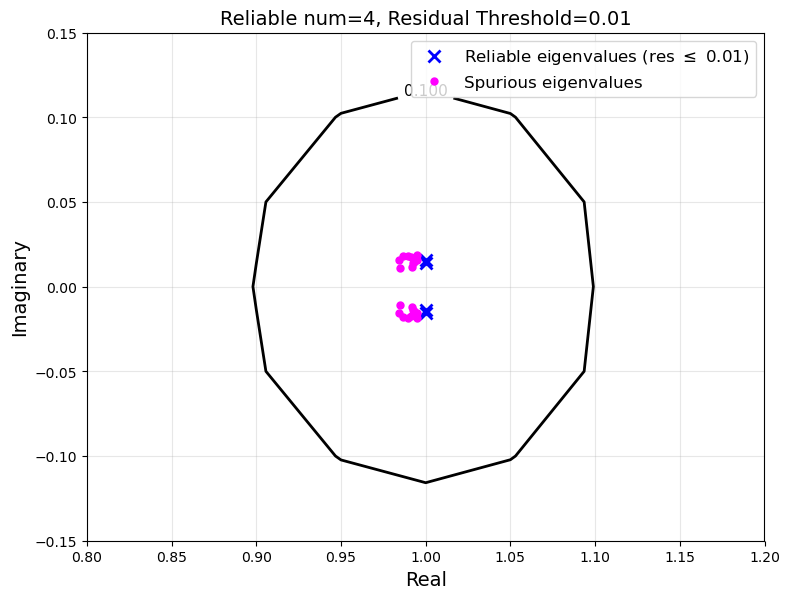

In [52]:
M = len(X_embed)-1
W = np.ones(M) / M
X = X_embed[:-1]
Y = X_embed[1:]
XH = kp.transform(X)
YH = kp.transform(Y)
G, A, L = compute_koopman_matrices(XH, W, YH)
eigenvalues, residuals, reliable_indices = plot_pseudospectra(G, A, L, residual_threshold=0.01,fixed_range=(0.8,1.20,-0.15,0.15))

In [55]:
print(eigenvalues)
print(residuals)

[0.99988962+0.01579086j 0.99988962-0.01579086j 0.9999187 +0.01411023j
 0.9999187 -0.01411023j 0.98611445+0.0232655j  0.98611445-0.0232655j
 0.96615838+0.01480294j 0.96615838-0.01480294j 0.97098057+0.01957951j
 0.97098057-0.01957951j 0.97031494+0.00871418j 0.97031494-0.00871418j
 0.97339263+0.01894907j 0.97339263-0.01894907j 0.97654919+0.0180596j
 0.97654919-0.0180596j  0.97871684+0.0148862j  0.97871684-0.0148862j
 0.97700904+0.01171545j 0.97700904-0.01171545j 0.97514213+0.01333648j
 0.97514213-0.01333648j 0.97592392+0.01563374j 0.97592392-0.01563374j]
[0.004828733517890222, 0.004828733517890577, 0.004665688619715933, 0.004665688619693343, 0.06538469502580879, 0.0653846950258271, 0.24173701449006846, 0.2417370144900633, 0.23388109024566817, 0.2338810902456655, 0.22597856355319448, 0.22597856355322718, 0.19940377356262834, 0.19940377356258798, 0.2094856832555156, 0.2094856832555156, 0.20117647848752948, 0.2011764784874975, 0.18077687682948315, 0.18077687682946053, 0.20122031897455275, 0.

In [35]:
print(eigenvalues)
print(residuals)

[0.99988962+0.01579086j 0.99988962-0.01579086j 0.9999187 +0.01411023j
 0.9999187 -0.01411023j 0.98611445+0.0232655j  0.98611445-0.0232655j
 0.96615838+0.01480294j 0.96615838-0.01480294j 0.97098057+0.01957951j
 0.97098057-0.01957951j 0.97031494+0.00871418j 0.97031494-0.00871418j
 0.97339263+0.01894907j 0.97339263-0.01894907j 0.97654919+0.0180596j
 0.97654919-0.0180596j  0.97871684+0.0148862j  0.97871684-0.0148862j
 0.97700904+0.01171545j 0.97700904-0.01171545j 0.97514213+0.01333648j
 0.97514213-0.01333648j 0.97592392+0.01563374j 0.97592392-0.01563374j]
[0.004828733517890222, 0.004828733517890577, 0.004665688619715933, 0.004665688619693343, 0.06538469502580879, 0.0653846950258271, 0.24173701449006846, 0.2417370144900633, 0.23388109024566817, 0.2338810902456655, 0.22597856355319448, 0.22597856355322718, 0.19940377356262834, 0.19940377356258798, 0.2094856832555156, 0.2094856832555156, 0.20117647848752948, 0.2011764784874975, 0.18077687682948315, 0.18077687682946053, 0.20122031897455275, 0.

In [41]:
# 紧凑打印（数组形式）
print("特征值 (保留3位小数)：", np.round(eigenvalues, 3))
print("残差 (保留3位小数)：", np.round(residuals, 3))

特征值 (保留3位小数)： [1.   +0.016j 1.   -0.016j 1.   +0.014j 1.   -0.014j 0.986+0.023j
 0.986-0.023j 0.966+0.015j 0.966-0.015j 0.971+0.02j  0.971-0.02j
 0.97 +0.009j 0.97 -0.009j 0.973+0.019j 0.973-0.019j 0.977+0.018j
 0.977-0.018j 0.979+0.015j 0.979-0.015j 0.977+0.012j 0.977-0.012j
 0.975+0.013j 0.975-0.013j 0.976+0.016j 0.976-0.016j]
残差 (保留3位小数)： [0.005 0.005 0.005 0.005 0.065 0.065 0.242 0.242 0.234 0.234 0.226 0.226
 0.199 0.199 0.209 0.209 0.201 0.201 0.181 0.181 0.201 0.201 0.178 0.178]


(<Figure size 640x480 with 2 Axes>, <Axes: >)

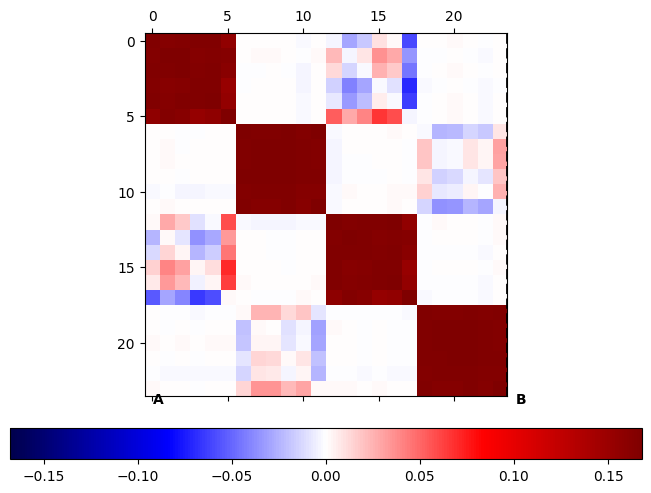

In [36]:
kp.regressor_.plot_koopman_matrix()

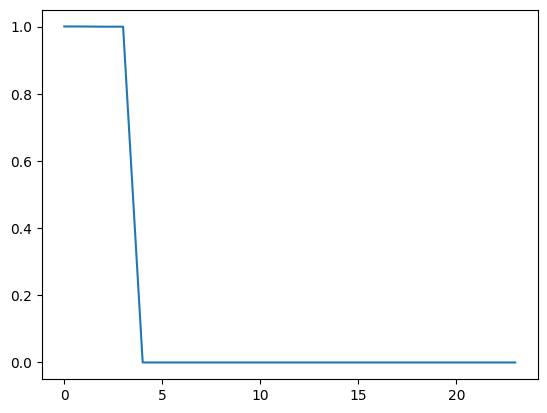

In [38]:
KM = kp.regressor_.coef_
U,S,V = np.linalg.svd(KM)
plt.figure()
plt.plot(S)
plt.show()

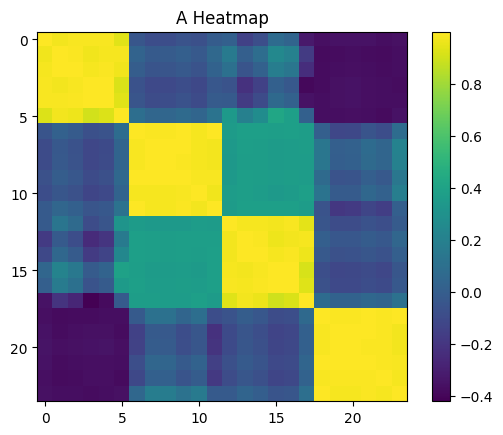

In [37]:
plt.imshow(A, cmap='viridis')  # imshow是热力图核心函数，cmap指定配色（可换）
plt.colorbar()  # 显示颜色条（直观查看数值对应关系）
plt.title('A Heatmap')  # 可选：添加标题
plt.show()  # 显示图片

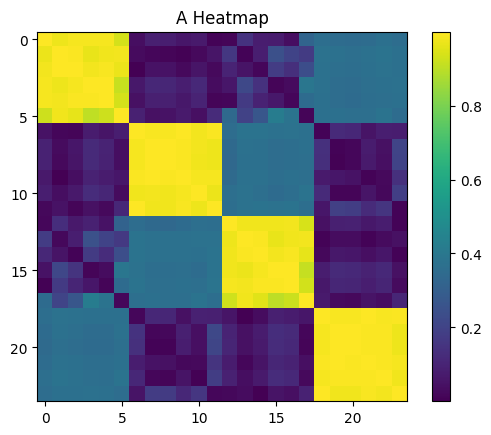

In [40]:
plt.imshow(np.abs(A), cmap='viridis')  # imshow是热力图核心函数，cmap指定配色（可换）
plt.colorbar()  # 显示颜色条（直观查看数值对应关系）
plt.title('A Heatmap')  # 可选：添加标题
plt.show()  # 显示图片

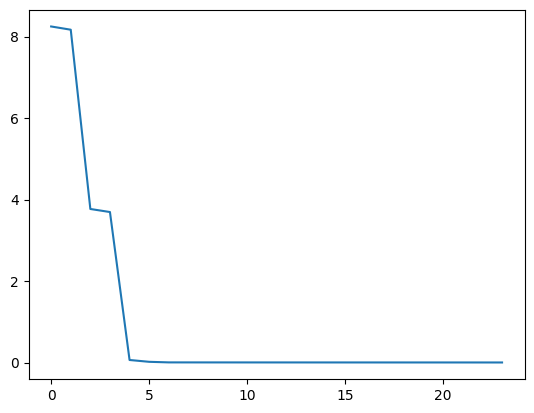

In [39]:
UA,SA,VA = np.linalg.svd(A)
plt.figure()
plt.plot(SA)
plt.show()

# 比较不同的积分方法

In [7]:
def monte_carlo_integration_data(data, n_points=30):
    """
    使用蒙特卡洛方法处理轨迹数据
    
    Parameters:
    data: 原始轨迹数据 (N x 4)
    n_points: 采样点数量
    
    Returns:
    processed_data: 处理后的数据 (n_points x 4)
    weights: 对应的权重
    indices: 采样点位置
    """
    n_original = len(data)
    
    # 生成随机时间点
    random_indices = np.random.uniform(0, n_original-1, n_points)
    
    processed_data = []
    for t in random_indices:
        idx_low = int(np.floor(t))
        idx_high = min(idx_low + 1, n_original - 1)
        frac = t - idx_low
        
        # 线性插值
        interpolated_point = (1 - frac) * data[idx_low] + frac * data[idx_high]
        processed_data.append(interpolated_point)
    
    # 蒙特卡洛方法的权重均匀分布
    weights = np.ones(n_points) / n_points
    
    return np.array(processed_data), weights, random_indices

def gauss_legendre_integration_data(data, n_points=20):
    """
    使用高斯-勒让德方法处理轨迹数据
    
    Parameters:
    data: 原始轨迹数据 (N x 4)
    n_points: 采样点数量
    
    Returns:
    processed_data: 处理后的数据 (n_points x 4)
    weights: 对应的权重
    indices: 采样点位置
    """
    n_original = len(data)
    
    # 获取高斯-勒让德节点和权重
    nodes, weights = np.polynomial.legendre.leggauss(n_points)
    
    # 将节点从[-1,1]映射到[0, n_original-1]
    mapped_nodes = 0.5 * (n_original - 1) * (nodes + 1)
    
    processed_data = []
    for t in mapped_nodes:
        idx_low = int(np.floor(t))
        idx_high = min(idx_low + 1, n_original - 1)
        frac = t - idx_low
        
        # 线性插值
        interpolated_point = (1 - frac) * data[idx_low] + frac * data[idx_high]
        processed_data.append(interpolated_point)
    
    # 调整权重以适应新的区间并归一化
    weights = weights * 0.5 * (n_original - 1)
    weights = weights / np.sum(weights)  # 归一化
    
    return np.array(processed_data), weights, mapped_nodes

def trapezoidal_integration_data(data, n_points=25):
    """
    使用梯形法则思路处理轨迹数据（均匀采样）
    
    Parameters:
    data: 原始轨迹数据 (N x 4)
    n_points: 采样点数量
    
    Returns:
    processed_data: 处理后的数据
    weights: 对应的权重
    indices: 采样点位置
    """
    n_original = len(data)
    
    # 均匀采样指定数量的点
    indices = np.linspace(0, n_original-1, n_points, dtype=int)
    processed_data = data[indices]
    
    # 梯形法则的权重（端点权重为0.5，中间为1）
    weights = np.ones(n_points)
    weights[0] = 0.5
    weights[-1] = 0.5
    
    # 归一化权重
    weights = weights / np.sum(weights)
    
    return processed_data, weights, indices.astype(float)

def riemann_sum_integration_data(data, n_points=25, method='midpoint'):
    """
    使用黎曼和思路处理轨迹数据
    
    Parameters:
    data: 原始轨迹数据 (N x 4)
    n_points: 采样点数量
    method: 'left', 'right', 'midpoint'
    
    Returns:
    processed_data: 处理后的数据
    weights: 对应的权重
    indices: 采样点位置
    """
    n_original = len(data)
    
    # 计算每个区间的长度
    interval_length = n_original / n_points
    
    processed_data = []
    indices = []
    
    for i in range(n_points):
        start_idx = i * interval_length
        end_idx = min((i + 1) * interval_length, n_original)
        
        if method == 'left':
            # 使用区间左端点
            point_idx = start_idx
        elif method == 'right':
            # 使用区间右端点
            point_idx = min(end_idx - 1, n_original - 1)
        elif method == 'midpoint':
            # 使用区间中点
            point_idx = (start_idx + end_idx) / 2
        
        # 找到最近的整数索引进行插值
        idx_low = int(np.floor(point_idx))
        idx_high = min(idx_low + 1, n_original - 1)
        frac = point_idx - idx_low
        
        # 线性插值
        interpolated_point = (1 - frac) * data[idx_low] + frac * data[idx_high]
        processed_data.append(interpolated_point)
        indices.append(point_idx)
    
    # 黎曼和的权重均匀分布
    weights = np.ones(n_points) / n_points
    
    return np.array(processed_data), weights, np.array(indices)

In [10]:
def plot_quadrature_errors(kp):
    """绘制求积误差图 - 修复参考线和主曲线问题"""
    N=12
    data_noisy, K_matrix, _,_ = plot_clustered_kuramoto(N=N, n_clusters=2, K_intra=5, K_inter=0.1,noise=0.01,T=100)
    #data_noisy = generate_sir_data(M=150)
    X,W,indices = gauss_legendre_integration_data(data_noisy, n_points=1000)
    #mc_data, mc_weights, mc_indices = monte_carlo_integration_data(data_noisy, n_points=1000)
    #gl_data, gl_weights, gl_indices = gauss_legendre_integration_data(data_noisy, n_points=1000)
    #ri_data, ri_weights, ri_indices =  riemann_sum_integration_data(data_noisy, n_points=1000)
    #ti_data, ti_weights, ti_indices = trapezoidal_integration_data(data_noisy, n_points=1000)
    Y = data_noisy[np.minimum(indices + 1, len(data_noisy) - 1).astype(int)]
    XH = kp.transform(X)
    YH = kp.transform(Y)
    G, test_ref, L = compute_koopman_matrices(XH, W, YH)

    # 样本大小向量 - 确保唯一性
    Mvec = np.unique(np.round(10**(np.arange(0.2, 4.05, 0.05))).astype(int))
    Mvec = Mvec[Mvec != 200]  # 移除200如果存在
    Mvec = np.append(Mvec, 201)  # 添加201
    Mvec = np.sort(Mvec)  # 确保排序
    
    methods = ['monte_carlo', 'gauss_legendre', 'trapezoidal', 'riemann_sum']
    me = len(methods)
    E = np.zeros((len(Mvec), me))
    method_functions = {
        'monte_carlo': monte_carlo_integration_data,
        'gauss_legendre': gauss_legendre_integration_data,
        'trapezoidal': trapezoidal_integration_data,
        'riemann_sum': riemann_sum_integration_data}
    
    #data_noisyN = generate_sir_data(M=150)
    for ct, j in enumerate(Mvec):
        for k in range(me):
            method_name = methods[k]
            method_func = method_functions[method_name]
            XX,WW,indicesN = method_func(data_noisy, n_points=j)
            YY = data_noisy[np.minimum(indicesN + 1, len(data_noisy) - 1).astype(int)]
            XHH = kp.transform(XX)
            YHH = kp.transform(YY)
            A_mat = compute_koopman_matrices(XHH,WW,YHH)[1]
            E[ct, k] = np.max(np.abs(test_ref - A_mat))
    
    # 绘制结果
    plt.figure(figsize=(8, 6))
    
    # 主曲线 - 确保每条线只绘制一次
    #methods = ['Monte Carlo', 'Gauss--Legendre', 'Trapezoidal', 'Riemann sum']
    colors = ['purple', 'blue', 'red', 'orange']
    
    for k in range(me):
        # 过滤掉NaN值
        valid_mask = ~np.isnan(E[:, k]) & (E[:, k] > 0)
        if np.any(valid_mask):
            plt.loglog(Mvec[valid_mask], E[valid_mask, k], linewidth=2, 
                      label=methods[k], color=colors[k])
    
    # 参考线
    mask = Mvec >= 20  # 扩大范围
    
    # 调整比例常数以避免重叠
    plt.loglog(Mvec[mask], 10 / Mvec[mask], 'k:', linewidth=2, 
               alpha=0.7, label=r'$O(1/M)$')
    plt.loglog(Mvec[mask], 200 / Mvec[mask]**2, 'k--', linewidth=2, 
               alpha=0.7, label=r'$O(1/M^2)$')
    plt.loglog(Mvec[mask], 5 / np.sqrt(Mvec[mask]), 'k-.', linewidth=2, 
               alpha=0.7, label=r'$O(1/\sqrt{M})$')
    
    # 格式化
    plt.legend(fontsize=12, loc='lower right', framealpha=0.7)
    plt.xlabel('Sample size M', fontsize=14)
    plt.ylabel('Max Error', fontsize=14)
    plt.xlim(1, 10000)
    #plt.ylim(1e-15, 10)
    plt.grid(True, alpha=0.3, which='both')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('Quadrature Errors Convergence', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return E

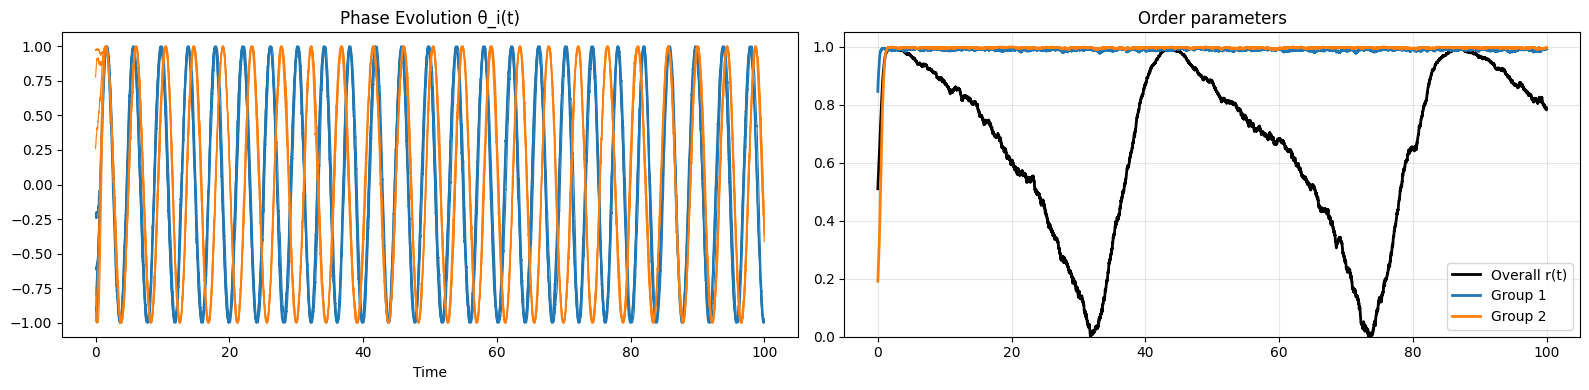

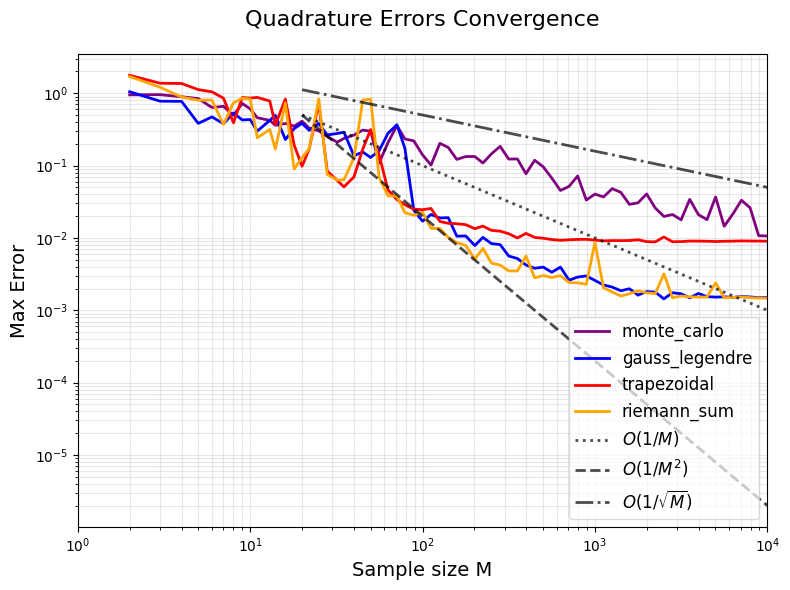

array([[9.49143084e-01, 1.04778595e+00, 1.76793059e+00, 1.70127701e+00],
       [9.54639830e-01, 7.75729185e-01, 1.37438582e+00, 1.20862190e+00],
       [8.93481578e-01, 7.71196054e-01, 1.36143309e+00, 8.85529496e-01],
       [8.42304212e-01, 3.82466558e-01, 1.12069224e+00, 7.99963526e-01],
       [6.35134150e-01, 4.70240218e-01, 1.04509039e+00, 8.03012819e-01],
       [6.58732729e-01, 3.78716768e-01, 8.53201559e-01, 3.70828963e-01],
       [4.94261740e-01, 5.33813013e-01, 3.89965513e-01, 7.35391798e-01],
       [7.21086281e-01, 4.26652654e-01, 8.71622214e-01, 8.51868672e-01],
       [6.08614267e-01, 4.32779335e-01, 8.56090703e-01, 8.30707416e-01],
       [4.58121961e-01, 2.99753987e-01, 8.75103336e-01, 2.42135301e-01],
       [4.21085401e-01, 4.21164506e-01, 7.78706428e-01, 3.15543251e-01],
       [3.60525661e-01, 4.95279673e-01, 3.64887612e-01, 1.68811876e-01],
       [3.81084411e-01, 2.29095220e-01, 8.29302603e-01, 7.33832337e-01],
       [3.50375352e-01, 3.24208216e-01, 1.91831599e

In [11]:
plot_quadrature_errors(kp)

In [ ]:
# 蒙特卡罗
#eigenvaluesker, residualsker, reliable_indicesker = plot_main(kpker, X_embed)

# 高斯勒让德
#X,W,indices = gauss_legendre_integration_data(X_embed, n_points=10000)
#Y = X_embed[np.minimum(indices + 1, len(X_embed) - 1).astype(int)]
#XHpl = kppl.transform(X)
#YHpl = kppl.transform(Y)
#Gpl, Apl, Lpl = compute_koopman_matrices(XHpl, W, YHpl)
#eigenvaluespl, residualspl, reliable_indicespl = plot_pseudospectra(Gpl, Apl, Lpl, residual_threshold=0.01,fixed_range=(0.8,1.2,-0.15,0.15))

# 梯形
#X,W,indices = trapezoidal_integration_data(X_embed, n_points=10000)
#Y = X_embed[np.minimum(indices + 1, len(X_embed) - 1).astype(int)]
#XHpl = kppl.transform(X)
#YHpl = kppl.transform(Y)
#Gpl, Apl, Lpl = compute_koopman_matrices(XHpl, W, YHpl)
#eigenvaluespl, residualspl, reliable_indicespl = plot_pseudospectra(Gpl, Apl, Lpl, residual_threshold=0.01,fixed_range=(0.8,1.2,-0.15,0.15))
